In [26]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

ds = xr.open_dataset("/data/pca_act/000_clean.nc")

stack = np.empty((0,400,400))
ti_nan = (np.count_nonzero(np.isnan(ds.nbart_blue.values), axis=(1,2)))<.66*160000
ds = ds.isel(time=ti_nan)
#np.save(f"m3_times", ds.time.values)

#for fname in ds:
for fname in ['nbart_red']:
    band = ds[fname].values/1e4
    stack = np.append(stack, band, axis=0)
    
stack = stack.reshape(stack.shape[0], -1)

print(np.nanmax(stack))
print(stack.shape)

0.28060001134872437
(71, 160000)


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
class AE(nn.Module):
    def __init__(self, n_comps, n_coeffs):
        super(AE, self).__init__()
        self.n_coeffs = n_coeffs
        self.n_comps = n_comps
        self.D = nn.Linear(1, self.n_comps*404*404, bias=False)
        self.conv1 = nn.Conv2d(self.n_comps, 2*self.n_comps, kernel_size=5)
        self.coeffs = nn.Linear(1, 2*self.n_comps*self.n_coeffs, bias=False)
        
    def forward(self, x):
        base = self.D(x)
        conv1 =  torch.tanh(self.conv1(base.reshape(1, self.n_comps, 404, 404)))   
        coeffs = self.coeffs(x).view(2*self.n_comps, self.n_coeffs)
        return torch.einsum('ik,kj->ji', conv1.view(400*400, 2*self.n_comps), coeffs)


def nan_mse_loss(output, target):
    loss = torch.mean((output[target == target] - target[target == target])**2)
    return loss


ncomps = 12

ncoeffs = stack.shape[0]

input = torch.ones(1, device=device)
tmean = np.nanmean(stack, axis=0)
#np.save(f"m3_mean", tmean)

target = torch.from_numpy(stack-tmean).float().to(device)

net = AE(ncomps, ncoeffs)
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)

epochs = 100
    
for it in range(epochs):
    # training loop:
    output = net(input)

    #sparsity = 0.00001 * torch.linalg.norm(net.coeffs.weight, 1)
    #magnitude = torch.linalg.norm(torch.linalg.norm(list(net.parameters())[0], 'fro') - 1, 2)
    loss = nan_mse_loss(output, target)# + sparsity

    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()
    optimizer.step()    # does the update

    prev_loss = loss.item()

    if it % 100 == 0:
        print(it, loss.item(), nan_mse_loss(output, target).item())
        
        
params = list(net.parameters())
for param in params:
    print(param.shape)

base = params[0].cpu().detach().numpy()
coeffs = params[1].cpu().detach().numpy()

#np.save(f"m3_base", base)
#np.save(f"m3_coeffs", coeffs)

cuda:0
0 0.7193249464035034 0.7193249464035034
torch.Size([1958592, 1])
torch.Size([24, 12, 5, 5])
torch.Size([24])
torch.Size([1704, 1])


(71, 400, 400)

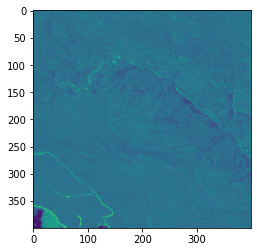

In [30]:
net.eval()

stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400)
plt.imshow(stack_hat[30])

stack_hat.shape

In [29]:
np.nanmean(np.square(stack[:71,:].reshape(-1,400,400)-(stack_hat[:71,:]+tmean.reshape(400,400))))

1.4711777061510027e-05

(497, 400, 400)

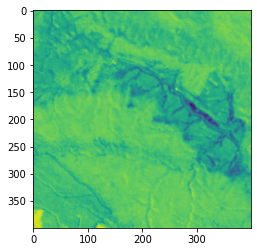

In [8]:
net.eval()

stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400)
plt.imshow(stack_hat[60])

stack_hat.shape

In [24]:
np.nanmean(np.square(stack[:71,:].reshape(-1,400,400)-(stack_hat[:71,:]+tmean.reshape(400,400))))

2.6022132108975136e-05

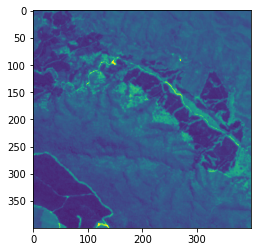

In [21]:
plt.imshow(stack_hat[30]+tmean.reshape(400,400),vmin=0,vmax=0.15)

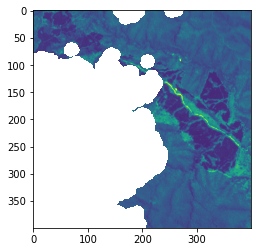

In [22]:
plt.imshow((stack).reshape(-1,400,400)[30],vmin=0,vmax=0.15)